**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [10]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['tri']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
from SimPEG import (Mesh, Directives, Maps, 
                    InvProblem, Optimization, DataMisfit, 
                    Inversion, Utils, Regularization)

import SimPEG.PF as PF
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
work_dir = r"C:\Users\DominiqueFournier\Downloads\octree_25m_15m_MVI_S_0111"

mesh = Mesh.TreeMesh.readUBC(work_dir + "\OctreeMesh.msh")

In [3]:
model = mesh.readModelUBC(work_dir + "\MVI_C_TOT.amp")

(5836450.5, 5842250.5)

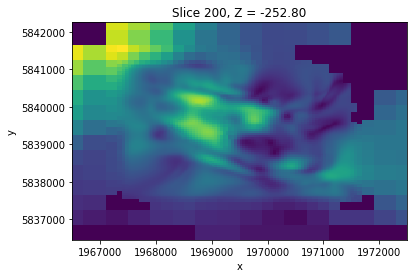

In [14]:
axs = plt.subplot()
mesh.plotSlice(model, normal='Z', ind=200, ax=axs, grid=False)
axs.set_xlim(mesh.gridCC[:,0].min(),mesh.gridCC[:,0].max())
axs.set_ylim(mesh.gridCC[:,1].min(),mesh.gridCC[:,1].max())

In [12]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90., 0.)

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
h = [5,5,5]
padDist = np.ones((3,2)) * 100

# Create grid of points for topography
# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(np.linspace(-200,200,50), np.linspace(-200,200,50))
b = 100
A = 50
zz = A*np.exp(-0.5*((xx/b)**2. + (yy/b)**2.))

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Create and array of observation points
xr = np.linspace(-100., 100., 20)
yr = np.linspace(-100., 100., 20)
X, Y = np.meshgrid(xr, yr)
Z = A*np.exp(-0.5*((X/b)**2. + (Y/b)**2.)) + 5

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField) 

# Create a topography
mesh = Utils.modelutils.meshBuilder(topo, h, padDist,
                                    meshType='TREE',
                                    verticalAlignment='center')

# Refine the mesh around topography
mesh = Utils.modelutils.refineTree(mesh, topo, dtype='surface',
                                   nCpad=[0, 5, 3], finalize=True)

# mesh = Utils.modelutils.refineTree(mesh, xyzLoc, dtype='surface',
#                                    nCpad=[2, 0, 0], finalize=True)


# Define an active cells from topo
actv = Utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'ActiveOctree.dat': actv})

In [13]:
mesh.nC

17501

In [4]:
# # Create a topography
# mesh = Utils.modelutils.meshBuilder(topo, h, padDist,
#                                     meshType='TREE',
#                                     verticalAlignment='center')

# # Refine the mesh around topography
# mesh = Utils.modelutils.refineTree(mesh, np.c_[-2.5,-2.5,-2.5], dtype='point',
#                                    nCpad=[1, 1, 1], finalize=True)

# Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
#                                models={'ActiveOctree.dat': actv})

<IPython.core.display.Javascript object>


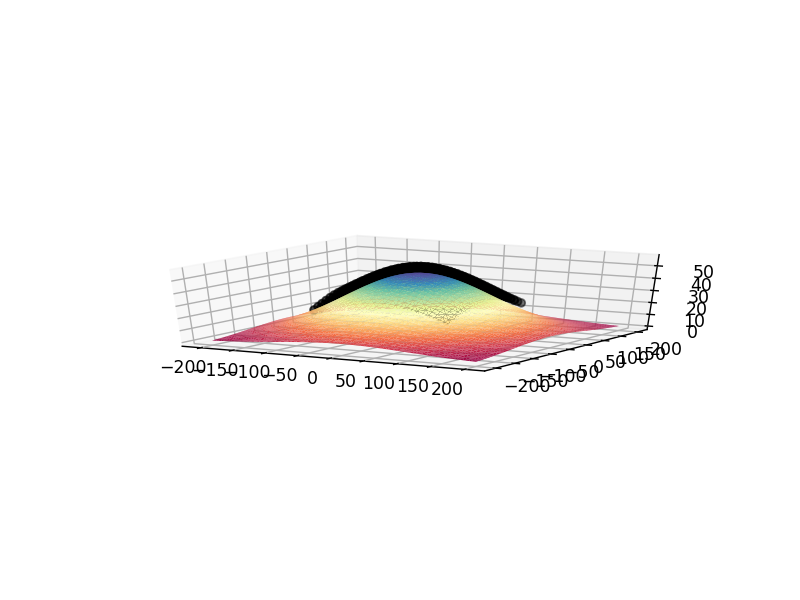

In [14]:
# Here how the topo looks with a quick interpolation, just a Gaussian...
tri = sp.spatial.Delaunay(topo)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(topo[:,0], topo[:,1], topo[:,2], triangles=tri.simplices, cmap=plt.cm.Spectral)
ax.scatter3D(xyzLoc[:,0],xyzLoc[:,1],xyzLoc[:,2], c='k')
ax.set_aspect(1./4)
plt.show()



Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [15]:

def plotVectorSectionsOctree(mesh, m, normal='X', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, actvMap=None, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    normalInd = {'X': 0, 'Y': 1, 'Z': 2}[normal]
    antiNormalInd = {'X': [1, 2], 'Y': [0, 2], 'Z': [0, 1]}[normal]

    h2d = (mesh.h[antiNormalInd[0]], mesh.h[antiNormalInd[1]])
    x2d = (mesh.x0[antiNormalInd[0]], mesh.x0[antiNormalInd[1]])

    #: Size of the sliced dimension
    szSliceDim = len(mesh.h[normalInd])
    if ind is None:
        ind = int(szSliceDim//2)

    cc_tensor = [None, None, None]
    for i in range(3):
        cc_tensor[i] = np.cumsum(np.r_[mesh.x0[i], mesh.h[i]])
        cc_tensor[i] = (cc_tensor[i][1:] + cc_tensor[i][:-1])*0.5
    slice_loc = cc_tensor[normalInd][ind]

#     if type(ind) not in integer_types:
#         raise ValueError('ind must be an integer')

    #create a temporary TreeMesh with the slice through
    temp_mesh = Mesh.TreeMesh(h2d, x2d)
    level_diff = mesh.max_level - temp_mesh.max_level

    XS = [None, None, None]
    XS[antiNormalInd[0]], XS[antiNormalInd[1]] = np.meshgrid(cc_tensor[antiNormalInd[0]],
                                                             cc_tensor[antiNormalInd[1]])
    XS[normalInd] = np.ones_like(XS[antiNormalInd[0]])*slice_loc
    loc_grid = np.c_[XS[0].reshape(-1), XS[1].reshape(-1), XS[2].reshape(-1)]
    inds = np.unique(mesh._get_containing_cell_indexes(loc_grid))

    grid2d = mesh.gridCC[inds][:, antiNormalInd]
    levels = mesh._cell_levels_by_indexes(inds) - level_diff
    temp_mesh.insert_cells(grid2d, levels)
    tm_gridboost = np.empty((temp_mesh.nC, 3))
    tm_gridboost[:, antiNormalInd] = temp_mesh.gridCC
    tm_gridboost[:, normalInd] = slice_loc

    #interpolate values to mesh.gridCC if not 'CC'
#     if vType in ['F', 'E']:
#     aveOp = 'aveF2CC'
#     Av = getattr(mesh, aveOp)
#     print(Av.shape,actvMap.P.shape, m.shape)
    mx = (actvMap*m[:,0])
    my = (actvMap*m[:,1])
    mz = (actvMap*m[:,2])
    
    m = np.c_[mx, my, mz]
#     m = Av*m

    #interpolate values from mesh.gridCC to grid2d
    ind_3d_to_2d = mesh._get_containing_cell_indexes(tm_gridboost)
    v2d = m[ind_3d_to_2d, :]
    amp = np.sum(v2d**2., axis=1)**0.5
    
    if axs is None:
        fig = plt.figure()
        axs = plt.subplot(111)
    else:
        assert isinstance(ax, matplotlib.axes.Axes), "ax must be an matplotlib.axes.Axes"
        fig = ax.figure

#     out = temp_mesh.plotImage(v2d, ax=ax, grid=grid, showIt=showIt, clim=clim)

    if fill:
#         im2 = axs.contourf(xx, yy, model,
#                            30, vmin=vmin, vmax=vmax,
#                            cmap=cmap)

        im2 = temp_mesh.plotImage(amp, ax=axs, clim=[vmin, vmax], grid=True)
 
    axs.quiver(temp_mesh.gridCC[:,0],
               temp_mesh.gridCC[:,1],
               v2d[:,antiNormalInd[0]],
               v2d[:,antiNormalInd[1]],
               pivot='mid',
               scale_units="inches", scale=scale, linewidths=(1,),
               edgecolors=(vec),
               headaxislength=0.1, headwidth=10, headlength=30)

In [16]:
mesh.nC

17501

In [17]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = nC*3)

# Create the forward model operator
prob = PF.Magnetics.MagneticVector(mesh, chiMap = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)



In [18]:
# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
# model = Utils.ModelBuilder.addBlock(mesh.gridCC, np.zeros(mesh.nC), np.r_[-40,-40,-50], np.r_[40,40,0], 0.05)[actv]

model = np.zeros((mesh.nC, 3))

# first Block magnetized down towards West
ind = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-20, -20, -10], np.r_[20, 20, 25],
    mesh.gridCC,
)[0]
model[ind,:] = np.kron(np.ones((ind.shape[0],1)), np.c_[1, 0, 0]*0.05)

# # Second Block magnetized up towards West
# ind = Utils.ModelBuilder.getIndicesBlock(
#     np.r_[20, -20, -10], np.r_[55, 20, 25],
#     mesh.gridCC,
# )[0]
# model[ind,:] = np.kron(np.ones((ind.shape[0],1)), np.c_[0, 0, -1]*0.05)

# Remove air cells
model = model[actv,:]

In [19]:
# Compute linear forward operator and compute some data
data = prob.fields(Utils.mkvc(model))

std = 5  #nT
data += np.random.randn(len(data))*std
wd = np.ones(len(data))*std

survey.dobs = data
survey.std = wd

Begin forward: M=full, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


<IPython.core.display.Javascript object>


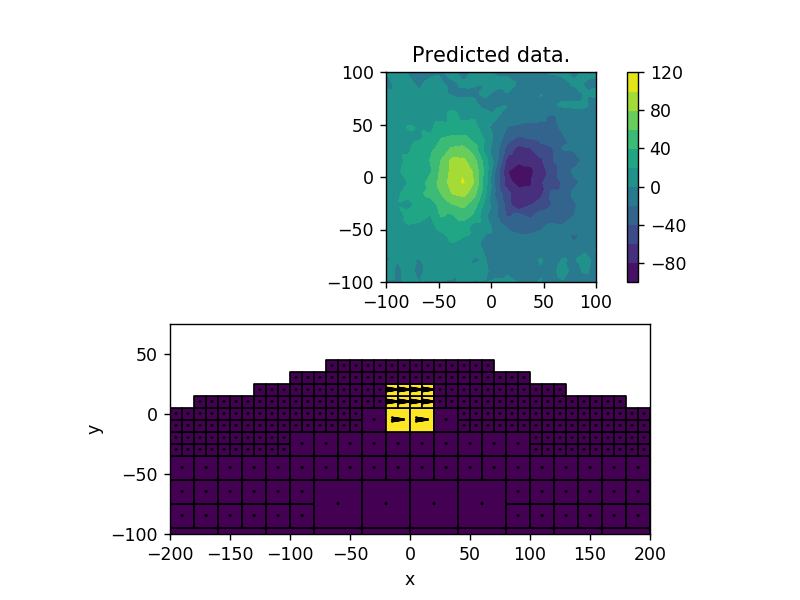

In [20]:
actvPlot = Maps.InjectActiveCells(mesh, actv, np.nan)
# Create a few models
plt.figure()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
ax = plt.subplot(2,1,1)
im = Utils.PlotUtils.plot2Ddata(xyzLoc, data, ax=ax)
plt.colorbar(im[0])
ax.set_title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')


ax = plt.subplot(2,1,2)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
plotVectorSectionsOctree(mesh, model, axs = ax, normal = 'Y', ind=66, actvMap = actvPlot, scale=0.5, vmin=0., vmax=0.01)
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()




Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [23]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs

# This Mapping connects all the regularizations together
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create sensitivity weights from our linear forward operator
# so that all cells get equal chance to contribute to the solution
wr = np.sum(prob.F**2., axis=0)**0.5
wr = (wr/np.max(wr))


# Create three regularization for the different components
# of magnetization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wr)
reg_p.mref = np.zeros(3*nC)

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wr)
reg_s.mref = np.zeros(3*nC)

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wr)
reg_t.mref = np.zeros(3*nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3*nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-10, upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=0, beta_tol = 5e-1)
update_Jacobi = Directives.UpdateJacobiPrecond()

saveOuput = Directives.SaveOutputEveryIteration()
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi, betaest])

# Run the inversion
m0 = np.ones(3*nC)  * 1e-4# Starting model
mrec_MVIC = inv.run(m0)

beta = invProb.beta

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Use Simple
Use Simple
Use Simple
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.76e+09  7.04e+03  1.21e-06  1.16e+04    1.97e+03      0              
   1  1.88e+09  6.55e+03  1.14e-06  8.68e+03    1.94e+03      0              


KeyboardInterrupt: 

In [14]:
PF.Magnetics.writeUBCobs('PredData.pre',survey,d=invProb.dpred)
PF.Magnetics.writeUBCobs('ObsData.pre',survey)

In [ ]:
mstart = Utils.matutils.xyz2atp(mrec_MVIC.reshape((nC,3),order='F'))

dmis.prob.coordinate_system = 'spherical'
dmis.prob.model = mstart

# Create a block diagonal regularization
wires = Maps.Wires(('amp', nC), ('theta', nC), ('phi', nC))

# Create a regularization
reg_a = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.amp)
reg_a.norms = np.c_[0, 0, 0, 0]
reg_a.mref = np.zeros(3*nC)


reg_t = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.theta)
reg_t.alpha_s = 0.  # No reference angle
reg_t.space = 'spherical'
reg_t.norms = np.c_[2, 0, 0, 0]
reg_t.eps_q = 2*np.pi

# reg_t.alpha_x, reg_t.alpha_y, reg_t.alpha_z = 0.25, 0.25, 0.25

reg_p = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.phi)
reg_p.alpha_s = 0.  # No reference angle
reg_p.space = 'spherical'
reg_p.norms = np.c_[2, 0, 0, 0]
reg_p.eps_q = 2*np.pi

reg = reg_a + reg_t + reg_p
reg.mref = np.zeros(3*nC)

Lbound = np.kron(np.asarray([0, -np.inf, -np.inf]), np.ones(nC))
Ubound = np.kron(np.asarray([10, np.inf, np.inf]), np.ones(nC))


# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=40,
                                 lower=Lbound,
                                 upper=Ubound,
                                 maxIterLS=10,
                                 maxIterCG=30, tolCG=1e-3,
                                 stepOffBoundsFact=1e-8,
                                 )
opt.approxHinv = None

invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta*10.)
#  betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
IRLS = Directives.Update_IRLS(f_min_change=1e-4, maxIRLSiter=40,
                              minGNiter=1, beta_tol = 0.5, prctile=98,
                              coolingRate=1, coolEps_q=True,
                              betaSearch=True)

# Special directive specific to the mag amplitude problem. The sensitivity
# weights are update between each iteration.
ProjSpherical = Directives.ProjSpherical()
update_SensWeight = Directives.UpdateSensitivityWeights()
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[ProjSpherical, IRLS, update_SensWeight,
                                             update_Jacobi])

mrec_MVI_S = inv.run(mstart)

In [ ]:
actvMapOut = Maps.InjectActiveCells(mesh, actv, 0)
PF.Magnetics.writeUBCobs('ObsSynthetic.obs',survey, survey.dobs)
vec_xyz = Utils.matutils.atp2xyz(mrec_MVI_S.reshape((nC, 3), order='F')).reshape((nC, 3), order='F')
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'RecMod.dat': actvMapOut*np.sum(vec_xyz**2., axis=1)**0.5})

In [ ]:
plt.figure()
ax = plt.subplot(2,1,1)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
plotVectorSectionsOctree(mesh, mrec_MVIC.reshape((nC,3), order="F"), axs = ax, normal = 'Y', ind=65, actvMap = actvPlot, scale=0.1, vmin=0., vmax=0.005)
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
# ax.set_title('A simple block model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2,1,2)
vec_xyz = Utils.matutils.atp2xyz(mrec_MVI_S.reshape((nC, 3), order='F')).reshape((nC, 3), order='F')
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
plotVectorSectionsOctree(mesh, vec_xyz, axs = ax, normal = 'Y', ind=65, actvMap = actvPlot, scale=0.5, vmin=0., vmax=0.01)
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
# ax.set_title('A simple block model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')


# ax = plt.subplot(2,1,2)
# # out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
# plotVectorSectionsOctree(mesh, model.reshape((nC,3), order="F"), axs = ax, normal = 'Y', ind=65, actvMap = actvPlot, scale=0.1, vmin=0., vmax=0.01)
# ax.set_xlim([-200,200])
# ax.set_ylim([-100,75])
# ax.set_title('A simple block model.')
# ax.set_xlabel('x');ax.set_ylabel('y')
# plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
plt.figure()
ax = plt.subplot(2, 1, 1)
Utils.PlotUtils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax)
ax.set_title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2, 1, 2)
Utils.PlotUtils.plot2Ddata(xyzLoc, data-invProb.dpred, ax=ax)
ax.set_title('Data residual.')
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
saveOuput.plot_misfit_curves()

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.